In [1]:
## Use the setup.py file to output directories. 
import sys
sys.path.append('/global/homes/z/zzhang13/BaryonPasting/CorrelatedStructures/multiDark/')

from setup import *
toolsdir = tools_dir()
repodir = repo_dir()
chainsdir = chains_dir()
datadir = data_dir()
plotdir = plots_dir()

sys.path.append(toolsdir)
sys.path.append(repodir)

In [2]:
with open(datadir + 'MDPL2_DS_R200c_SAGE_Ngal_allM_allz.p', 'rb') as handle:
    matched_halo_df = pickle.load(handle)
matched_halo_df.columns

Index(['scale', 'CtreesHaloID', 'pid', 'mvir', 'rvir', 'rs', 'x', 'y', 'z',
       'Mmvir_all', 'M200b', 'M200c', 'M500c', 'T/|U|', 'Halfmass_Scale',
       'Acc_Rate_Inst', 'Acc_Rate_100Myr', 'Acc_Rate_1*Tdyn',
       'Acc_Rate_2*Tdyn', 'Acc_Rate_Mpeak', 'c_vir', 'R200c', 'R500c',
       'redshift', 'Ngal_Dsep_1', 'Ngal_Rvir', 'Ngal_R200c', 'Ngal_R500c',
       'sigma', 'r_range', 'delta_sigma'],
      dtype='object')

## User Defined Functions

#### KLLR for Covariance

In [3]:
from kllr.kllr.regression_model import *
from kllr.kllr.regression_plotting import *
from kllr.kllr.calc_cov_KLLR import *

#### Likelihood functions and fit

In [4]:
from mcmc_reduced_model import *

## Data vectors

In [5]:
from data_bins import r_cent_lin_norm, r_cent_log_norm
from data_bins import mass_bins, mass_bin_cent
from data_bins import a_bins

### Dictionary of model specifications

In [6]:
model_dict ={
             'erf_reduced':{'Ndim':3, 'model_func':model_erf, 'x0':[0.5, -0.5, 5e11], 'x_final:':[],
                         }
            }

### Benchmark Testing using one bin

z=0.00, [1e14,2e14] normalized by R200c. 

In [ ]:
nBootstrap = 10
mass_min = 5e14; mass_max = 1e15
cur_a_bin = 0.6712

mask = (matched_halo_df.M200c >= mass_min) & (matched_halo_df.M200c < mass_max) & (matched_halo_df.scale == cur_a_bin) 
cur_df = matched_halo_df[mask]
print('M{:.2g}-{:.2g}, z={:.2f}, {}'.format(mass_min, mass_max, 1/cur_a_bin-1, len(cur_df)))
            
##Computing the Covariance##
##Compute Cov. and error total
xline, output = calc_cov_KLLR(np.log10(np.array(cur_df['M200c'],dtype=float)) , np.array(np.vstack(cur_df['delta_sigma']), dtype=float), \
                                np.log10(np.array(cur_df['Ngal_Dsep_1'],dtype=float)), nBootstrap=nBootstrap)
cov_ds_ngal_kllr = output['covariance']
cov_mean_kllr = np.mean(cov_ds_ngal_kllr, axis=0)
cov_err_kllr = np.std(cov_ds_ngal_kllr, axis=0)
        
##Data vector for chains
x_data = r_cent_log_norm; y_data = cov_mean_kllr; y_err = cov_err_kllr
        


In [ ]:
## Testing out the functions

for k,v in model_dict.items():
    #Ndim = model_dict['logistics']['Ndim']
    print(k)
    model = v['model_func']
    x0 = v['x0']
    plt.plot(x_data, model(x0, x_data), label=k)
    
plt.errorbar(x_data, y_data, yerr=y_err, label='Data')
plt.legend()
plt.show()

In [ ]:
import corner
##Running the chains
Nwalker = 50
Nsample = int(1e4)

mass_min = 5e14; mass_max = 1e15
cur_a_bin = 0.6712

redshift = 1/cur_a_bin - 1
redshift_str = '{:.2f}'.format(redshift)
redshift_str = redshift_str.replace('.','p')

mpl.style.use('default')
f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(10,8), sharex=True)

i=0
for k,v in model_dict.items():
    if k != 'erf': continue
    print(k)
    Ndim = v['Ndim']
    model = v['model_func']
    x0 = v['x0']
    
    
    filename = datadir+"test_chains_M{:.2g}_{:.2g}_z{}_{}.h5py".format(mass_min, mass_max, redshift_str, k)

    best_fit_params, chain = run_model_chains(Nwalker, Ndim, Nsample, model, x_data, y_data, y_err, x0, \
                     burn_in=500, thin=100, maxlag=1000, savefile=False, filename=filename, verbose=True)
    
    model_dict[k]['x_final'] = best_fit_params
    Ndim = model_dict[k]['Ndim']
    fit = model(best_fit_params[:,0], x_data)
    
    flatchain=chain.reshape((-1,Ndim)).T
    best_fit_params, DIC_model, BIC_model, p_val = posterior_summary_stats(flatchain, model, Ndim, x_data, y_data, y_err, verbose=True)
    
    a0.plot(x_data, fit, label=k, color='C{}'.format(i), linewidth=3)
    a1.errorbar(x_data, y_data-fit, yerr=y_err, marker="o", capsize=3, linestyle='None',color='C{}'.format(i), label=k)
    i+=1
    
a0.axhline(0, linestyle='--', color='black')
a0.errorbar(x_data, y_data, yerr=y_err, label='Cov', marker="o", capsize=3, linestyle='None', color='green')  
a0.legend(loc='upper left', fontsize=20)
a0.set_ylabel(r'$\rm{Cov}(\Delta\Sigma, N_{\rm gal})$', fontsize=20)

a1.axhline(0, linestyle='--', color='black')
#a1.set_ylim([-6e11,3e11])
a1.set_ylabel(r'$\rm{Cov}(\Delta\Sigma, N_{\rm gal})^{\rm Obs} - \rm{Cov}(\Delta\Sigma, N_{\rm gal})^{\rm Fit}$', fontsize=14)
a1.set_xlabel(r'$\log_{10}(R/R_{\rm vir})$', fontsize=20)

plt.suptitle(r'$M_{\rm vir} \in$' + '[{:.2g},{:.2g}), z={})'.format(5e13,1e14,0.00), fontsize=20)

f.tight_layout()
#f.savefig(plot_dir+'cov_all_models_data_vs_fit_M{:.2g}_{:.2g}_z{}.pdf'.format(mass_min, mass_max, redshift_str))
plt.show()


In [ ]:
plt.plot(chain[:,1,0])

In [ ]:
import corner
tmp = corner.corner(flatchain.T, labels=['gamma', 'tau', 'h', r'$10^{12}\times s$'],
                    quantiles=[0.16, 0.5, 0.84],
                    show_titles=True,
                    title_kwargs={"fontsize": 12},
                    title_fmt='.2g',
                    #axes_scale=['linear','linear','linear','log'],
                    max_n_ticks=3,
                    use_math_text=True,
                    #range=[(0,0.4),(-2,0),(0.9,1),(1e10,1e13)]
                   )
for i, ax in enumerate(tmp.get_axes()):
    #if i==12: ax.set_xscale('log')
    #if i>=13: ax.set_yscale('log')
    ax.tick_params(axis='both', labelsize=12)
#tmp.savefig(plot_dir + 'mcmc_logistic_cornerplot.pdf')

In [ ]:
plot_best_fit_params(model_dict)

### Run for all

### Binning and configuration

In [ ]:
mass_bin_edges = [5e13, 1e14, 2e14, 5e14, 1e15]
#mass_bin_edges = [5e14, 1e15]
mass_bins = [[mass_bin_edges[i],mass_bin_edges[i+1]] for i in range(len(mass_bin_edges)-1)]
#a_bins = [1, 0.6712, 0.4922]
a_bins = [0.6712]

In [ ]:
## MCMC config
Nwalkers = 50
Nsample = int(2e4)
burn_in = 500
thin = 50 
maxlag=1000
#x0 = [0.5,-0.5,-1,1e11]

In [ ]:
radius_bins_dir = {'R200c_binned_Dsep_1Mpc':'R200c_binned/Dsep_1/', \
                   'R200c_binned_Dsep_R200c':'R200c_binned/Dsep_R200c/', \
                   'Rvir_binned_Dsep_1':'Rvir_binned/Dsep_1/', \
                   'Rvir_binned_Dsep_Rvir':'Rvir_binned/Dsep_Rvir/'}

In [ ]:
from scipy import stats
import scipy.optimize as opt
import emcee
import tqdm

nBootstrap = 20

#fig, axs = plt.subplots(4,3,figsize=(18,18), tight_layout=True, sharex=True)

for i, cur_mass_bin in enumerate(mass_bins):
    for j, cur_a_bin in enumerate(a_bins):     
            mass_min = cur_mass_bin[0]; mass_max = cur_mass_bin[1]
            mask = (matched_halo_df.M200c >= mass_min) & (matched_halo_df.M200c < mass_max) & (matched_halo_df.scale == cur_a_bin) 
            cur_df = matched_halo_df[mask]
            print('M{:.2g}-{:.2g}, z={:.2f}, {}'.format(mass_min, mass_max, 1/cur_a_bin-1, len(cur_df)))

            redshift = 1/cur_a_bin - 1
            redshift_str = '{:.2f}'.format(redshift)
            redshift_str = redshift_str.replace('.','p')

            if len(cur_df) < 100: 
                #axs[i,j].set_visible(False)
                continue

            ##Computing the Covariance##
            ##Compute Cov. and error total
            xline, output = calc_cov_KLLR(np.log10(np.array(cur_df['M200c'],dtype=float)) , np.array(np.vstack(cur_df['delta_sigma']), dtype=float), \
                                           np.log10(np.array(cur_df['Ngal_R200c'],dtype=float)), nBootstrap=nBootstrap)
            cov_ds_ngal_kllr = output['covariance']
            cov_mean_kllr = np.mean(cov_ds_ngal_kllr, axis=0)
            cov_err_kllr = np.std(cov_ds_ngal_kllr, axis=0)

            ##Data vector for chains
            x_data = r_cent_log_norm; y_data = cov_mean_kllr; y_err = cov_err_kllr

            f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(8,6), sharex=True)
            k=0
            for key, value in model_dict.items():
                print(key)
                if key != 'erf': continue 
                Ndim = value['Ndim']
                model = value['model_func']
                x0 = value['x0']


                filename = chains_dir+"R200c_binned/Dsep_R200c/chains_M{:.2g}_{:.2g}_z{}_{}.h5py".format(mass_min, mass_max, redshift_str, key)

                best_fit_params, flatchain = run_model_chains(Nwalkers, Ndim, Nsample, model, x_data, y_data, y_err, x0, \
                                 burn_in=burn_in, thin=thin, maxlag=maxlag, savefile=True, filename=filename, verbose=True)

                model_dict[key]['x_final'] = best_fit_params
                fit = model(best_fit_params[:,0], x_data)


                a0.plot(x_data, fit, label=key, color='C{}'.format(k), linewidth=3)
                a1.errorbar(x_data, y_data-fit, yerr=y_err, marker="o", capsize=3, linestyle='None',color='C{}'.format(k), label=key)
                k+=1

            a0.axhline(0, linestyle='--', color='black')
            a0.errorbar(x_data, y_data, yerr=y_err, label='Cov', marker="o", capsize=3, linestyle='None', color='C5')  
            a0.legend(loc='lower right', fontsize=14)
            a0.set_ylabel(r'$\rm{Cov}(\Delta\Sigma, N_{\rm gal})$', fontsize=20)

            a1.axhline(0, linestyle='--', color='black')
            #a1.set_ylim([-6e11,3e11])
            a1.set_ylabel(r'$\Delta \rm{Cov}(\Delta\Sigma, N_{\rm gal})$', fontsize=14)
            a1.set_xlabel(r'$\log_{10}(R/R_{\rm vir})$', fontsize=20)

            plt.suptitle(r'$M_{\rm vir} \in$' + '[{:.2g},{:.2g}), z={})'.format(mass_min, mass_max, 1/cur_a_bin-1), fontsize=20)

            f.tight_layout()
            #f.savefig(plot_dir+'cov_all_models_data_vs_fit_M{:.2g}_{:.2g}_z{}.pdf'.format(mass_min, mass_max, redshift_str))
            plt.show()

In [ ]:
from scipy import stats
import scipy.optimize as opt
import emcee
import tqdm

nBootstrap = 20

#fig, axs = plt.subplots(4,3,figsize=(18,18), tight_layout=True, sharex=True)

for i, cur_mass_bin in enumerate(mass_bins):
    for j, cur_a_bin in enumerate(a_bins):     
            mass_min = cur_mass_bin[0]; mass_max = cur_mass_bin[1]
            mask = (matched_halo_df.M200c >= mass_min) & (matched_halo_df.M200c < mass_max) & (matched_halo_df.scale == cur_a_bin) 
            cur_df = matched_halo_df[mask]
            print('M{:.2g}-{:.2g}, z={:.2f}, {}'.format(mass_min, mass_max, 1/cur_a_bin-1, len(cur_df)))

            redshift = 1/cur_a_bin - 1
            redshift_str = '{:.2f}'.format(redshift)
            redshift_str = redshift_str.replace('.','p')

            if len(cur_df) < 100: 
                #axs[i,j].set_visible(False)
                continue

            ##Computing the Covariance##
            ##Compute Cov. and error total
            xline, output = calc_cov_KLLR(np.log10(np.array(cur_df['M200c'],dtype=float)) , np.array(np.vstack(cur_df['delta_sigma']), dtype=float), \
                                           np.log10(np.array(cur_df['Ngal_Dsep_1'],dtype=float)), nBootstrap=nBootstrap)
            cov_ds_ngal_kllr = output['covariance']
            cov_mean_kllr = np.mean(cov_ds_ngal_kllr, axis=0)
            cov_err_kllr = np.std(cov_ds_ngal_kllr, axis=0)

            ##Data vector for chains
            x_data = r_cent_log_norm; y_data = cov_mean_kllr; y_err = cov_err_kllr

            f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(8,6), sharex=True)
            k=0
            for key, value in model_dict.items():
                print(key)
                if key != 'erf': continue 
                Ndim = value['Ndim']
                model = value['model_func']
                x0 = value['x0']


                filename = chains_dir+"R200c_binned/Dsep_1/chains_M{:.2g}_{:.2g}_z{}_{}.h5py".format(mass_min, mass_max, redshift_str, key)

                best_fit_params, flatchain = run_model_chains(Nwalkers, Ndim, Nsample, model, x_data, y_data, y_err, x0, \
                                 burn_in=burn_in, thin=thin, maxlag=maxlag, savefile=True, filename=filename, verbose=True)

                model_dict[key]['x_final'] = best_fit_params
                fit = model(best_fit_params[:,0], x_data)


                a0.plot(x_data, fit, label=key, color='C{}'.format(k), linewidth=3)
                a1.errorbar(x_data, y_data-fit, yerr=y_err, marker="o", capsize=3, linestyle='None',color='C{}'.format(k), label=key)
                k+=1

            a0.axhline(0, linestyle='--', color='black')
            a0.errorbar(x_data, y_data, yerr=y_err, label='Cov', marker="o", capsize=3, linestyle='None', color='C5')  
            a0.legend(loc='lower right', fontsize=14)
            a0.set_ylabel(r'$\rm{Cov}(\Delta\Sigma, N_{\rm gal})$', fontsize=20)

            a1.axhline(0, linestyle='--', color='black')
            #a1.set_ylim([-6e11,3e11])
            a1.set_ylabel(r'$\Delta \rm{Cov}(\Delta\Sigma, N_{\rm gal})$', fontsize=14)
            a1.set_xlabel(r'$\log_{10}(R/R_{\rm vir})$', fontsize=20)

            plt.suptitle(r'$M_{\rm vir} \in$' + '[{:.2g},{:.2g}), z={})'.format(mass_min, mass_max, 1/cur_a_bin-1), fontsize=20)

            f.tight_layout()
            #f.savefig(plot_dir+'cov_all_models_data_vs_fit_M{:.2g}_{:.2g}_z{}.pdf'.format(mass_min, mass_max, redshift_str))
            plt.show()

## Configure the (M,z) bins to run

In [7]:
## MCMC config
Nwalkers = 50
Nsample = int(2e4)
burn_in = 500
thin = 50 
maxlag=1000
#x0 = [0.5,-0.5,-1,1e11]

In [8]:
mass_bin_edges = [5e13, 1e14, 2e14, 5e14, 1e15]
mass_bins = [[mass_bin_edges[i],mass_bin_edges[i+1]] for i in range(len(mass_bin_edges)-1)]
a_bins = [1, 0.6712, 0.4922]

M5e+13-1e+14, z=0.00, 500
erf_reduced


100%|██████████| 20000/20000 [02:27<00:00, 135.74it/s]


R = [1.00037521 1.00037443 1.00035248]
param_0: best fit, upper_err, lower_err:  [0.44128823 0.04708169 0.04117395]
param_1: best fit, upper_err, lower_err:  [-0.62693293  0.06984703  0.08783488]
param_2: best fit, upper_err, lower_err:  [2.65519531e+12 5.58650418e+11 3.91003095e+11]
DIC:  [1086.27607663]
BIC:  [1089.1757969]
Chi-square p-value:  0.00435543837261787
Starting params:  [ 4.31547465e-01 -6.10651209e-01  2.57492180e+12] Minimization convergence:  False


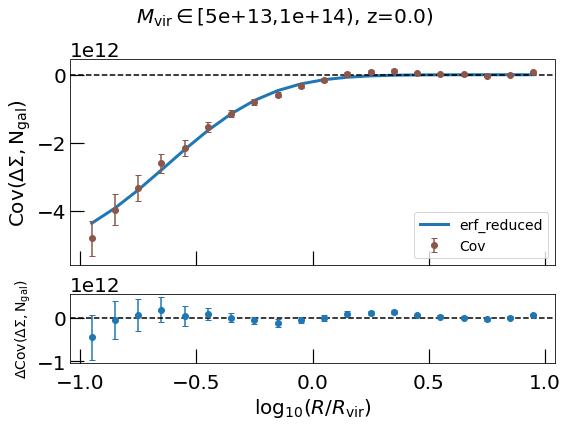

M5e+13-1e+14, z=0.49, 500
erf_reduced
Optimization terminated successfully.
         Current function value: 528.097843
         Iterations: 162
         Function evaluations: 385


100%|██████████| 20000/20000 [02:25<00:00, 137.77it/s]


R = [0.99972803 0.99970089 0.99981969]
param_0: best fit, upper_err, lower_err:  [0.25463919 0.0352085  0.03302137]
param_1: best fit, upper_err, lower_err:  [-0.34539489  0.03828274  0.04319686]
param_2: best fit, upper_err, lower_err:  [7.86631284e+11 7.56361295e+10 6.77573051e+10]
DIC:  [1062.36282641]
BIC:  [1065.20215884]
Chi-square p-value:  0.12738585987084328
Starting params:  [ 2.50869201e-01 -3.41057780e-01  7.83069262e+11] Minimization convergence:  True


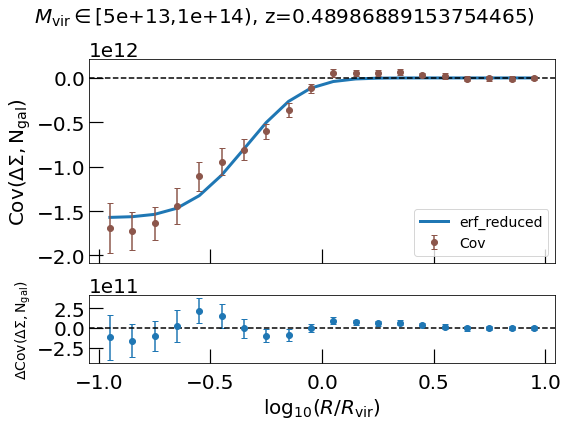

M5e+13-1e+14, z=1.03, 500
erf_reduced
Optimization terminated successfully.
         Current function value: 533.165166
         Iterations: 164
         Function evaluations: 376


100%|██████████| 20000/20000 [02:21<00:00, 141.25it/s]


R = [1.04259463 1.08743263 1.14787393]
param_0: best fit, upper_err, lower_err:  [0.20030057 0.06990597 0.05614542]
param_1: best fit, upper_err, lower_err:  [-0.34515309  0.05740666  0.07523365]
param_2: best fit, upper_err, lower_err:  [3.88466530e+11 7.37774088e+10 5.86876818e+10]
DIC:  [1073.08523331]
BIC:  [1075.43822729]
Chi-square p-value:  0.010459699502279096
Starting params:  [ 1.85491402e-01 -3.28472621e-01  3.81654428e+11] Minimization convergence:  True


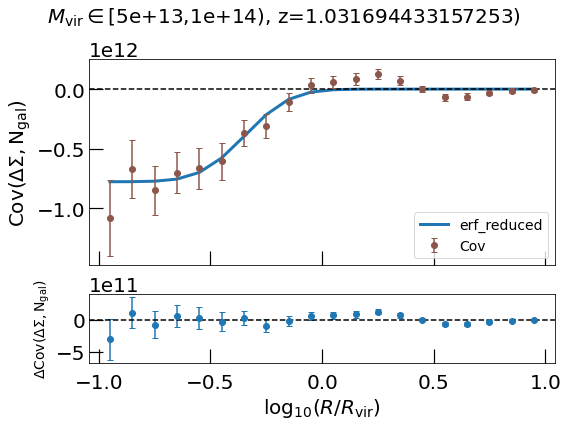

M1e+14-2e+14, z=0.00, 500
erf_reduced
Optimization terminated successfully.
         Current function value: 526.258379
         Iterations: 195
         Function evaluations: 444


100%|██████████| 20000/20000 [02:24<00:00, 138.53it/s]


R = [1.00168442 1.00182512 1.0022411 ]
param_0: best fit, upper_err, lower_err:  [0.68586468 0.10503481 0.0911042 ]
param_1: best fit, upper_err, lower_err:  [-0.98125971  0.19787679  0.2674715 ]
param_2: best fit, upper_err, lower_err:  [4.10084948e+12 2.31041239e+12 1.18634588e+12]
DIC:  [1058.11205862]
BIC:  [1061.62398026]
Chi-square p-value:  0.5023986907221368
Starting params:  [ 6.52290041e-01 -9.05650825e-01  3.62214380e+12] Minimization convergence:  True


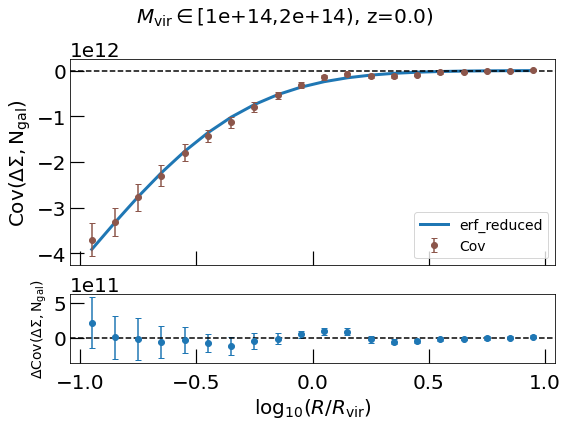

M1e+14-2e+14, z=0.49, 500
erf_reduced
Optimization terminated successfully.
         Current function value: 526.807739
         Iterations: 140
         Function evaluations: 348


100%|██████████| 20000/20000 [02:18<00:00, 144.20it/s]


R = [1.00429961 1.0069621  1.01405777]
param_0: best fit, upper_err, lower_err:  [0.38241139 0.14314593 0.0890003 ]
param_1: best fit, upper_err, lower_err:  [-0.47754425  0.12259993  0.24058416]
param_2: best fit, upper_err, lower_err:  [8.52604695e+11 4.64494151e+11 1.90818173e+11]
DIC:  [1060.64938474]
BIC:  [1062.96037562]
Chi-square p-value:  0.8609485997337458
Starting params:  [ 3.35761532e-01 -4.09170161e-01  7.60084549e+11] Minimization convergence:  True


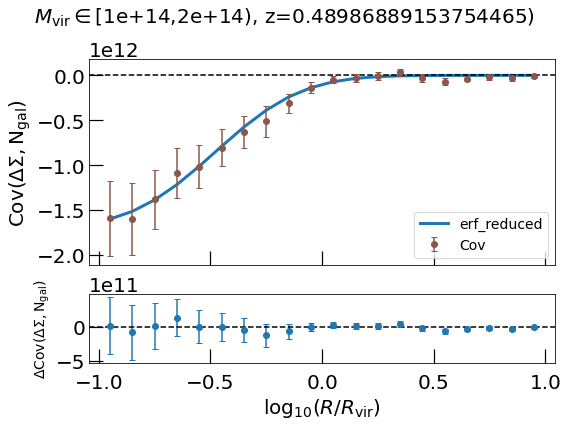

M1e+14-2e+14, z=1.03, 500
erf_reduced
Optimization terminated successfully.
         Current function value: 533.232152
         Iterations: 146
         Function evaluations: 360


100%|██████████| 20000/20000 [02:26<00:00, 136.52it/s]


R = [1.00038349 1.00013701 1.00004133]
param_0: best fit, upper_err, lower_err:  [0.22192531 0.0591694  0.05161509]
param_1: best fit, upper_err, lower_err:  [-0.42159622  0.06395348  0.07701214]
param_2: best fit, upper_err, lower_err:  [5.38813064e+11 1.14786703e+11 8.86862484e+10]
DIC:  [1072.8476456]
BIC:  [1075.52297948]
Chi-square p-value:  0.0064455210511559224
Starting params:  [ 2.15357601e-01 -4.08850576e-01  5.33373493e+11] Minimization convergence:  True


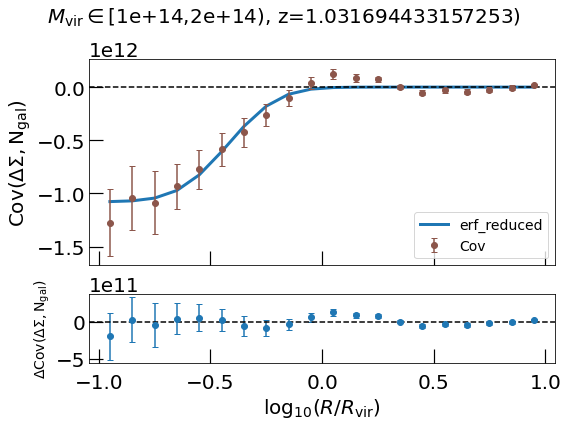

M2e+14-5e+14, z=0.00, 500
erf_reduced
Optimization terminated successfully.
         Current function value: 523.180225
         Iterations: 194
         Function evaluations: 429


100%|██████████| 20000/20000 [02:23<00:00, 139.14it/s]


R = [1.00033823 1.00049245 1.00061329]
param_0: best fit, upper_err, lower_err:  [0.39765069 0.03674478 0.03249222]
param_1: best fit, upper_err, lower_err:  [-0.50142908  0.05080349  0.06099324]
param_2: best fit, upper_err, lower_err:  [1.90493534e+12 2.57973849e+11 2.01640424e+11]
DIC:  [1052.50479472]
BIC:  [1055.39094054]
Chi-square p-value:  0.4027748165639129
Starting params:  [ 3.91016106e-01 -4.90617578e-01  1.86661102e+12] Minimization convergence:  True


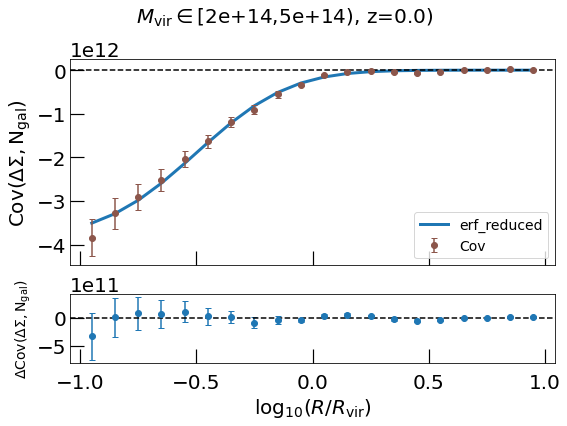

M2e+14-5e+14, z=0.49, 500
erf_reduced
Optimization terminated successfully.
         Current function value: 525.528995
         Iterations: 163
         Function evaluations: 378


100%|██████████| 20000/20000 [02:28<00:00, 134.82it/s]


R = [1.00589386 1.00833051 1.01281123]
param_0: best fit, upper_err, lower_err:  [0.24528147 0.20908433 0.12301058]
param_1: best fit, upper_err, lower_err:  [-0.5532146   0.14183714  0.42318068]
param_2: best fit, upper_err, lower_err:  [4.02347014e+11 6.87693702e+11 1.36430573e+11]
DIC:  [1058.35888079]
BIC:  [1060.53411088]
Chi-square p-value:  0.30092616124439164
Starting params:  [ 1.86661718e-01 -4.69535303e-01  3.47539734e+11] Minimization convergence:  True


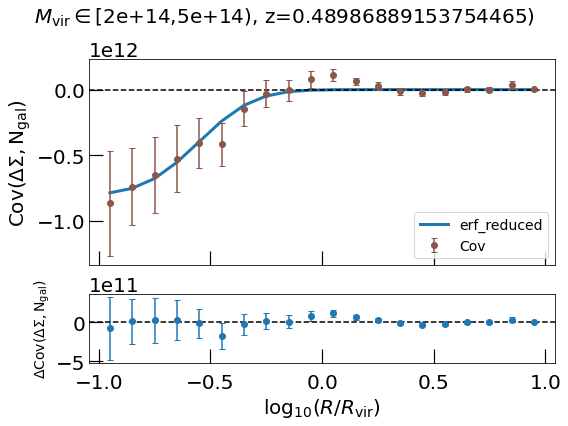

M2e+14-5e+14, z=1.03, 289
erf_reduced
Optimization terminated successfully.
         Current function value: 530.860628
         Iterations: 274
         Function evaluations: 560


100%|██████████| 20000/20000 [02:22<00:00, 139.97it/s]


R = [1.00390484 1.00282285 1.08269335]
param_0: best fit, upper_err, lower_err:  [5.97275189 2.76982297 3.00829042]
param_1: best fit, upper_err, lower_err:  [-0.55288864  3.2979085   2.988095  ]
param_2: best fit, upper_err, lower_err:  [1.97508500e+10 2.52904515e+10 7.41180061e+09]
DIC:  [1058.17520596]
BIC:  [1065.22530631]
Chi-square p-value:  0.14139182544395545
Starting params:  [ 1.59707701e-03 -1.49931828e-01  5.25582844e+10] Minimization convergence:  True


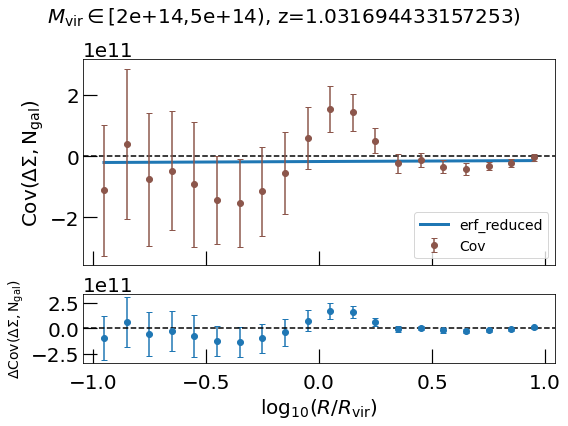

M5e+14-1e+15, z=0.00, 500
erf_reduced
Optimization terminated successfully.
         Current function value: 528.509858
         Iterations: 163
         Function evaluations: 383


100%|██████████| 20000/20000 [02:24<00:00, 138.17it/s]


R = [0.99971292 0.99987881 0.99979826]
param_0: best fit, upper_err, lower_err:  [0.29091994 0.03690068 0.03291658]
param_1: best fit, upper_err, lower_err:  [-0.39562735  0.04370343  0.0491344 ]
param_2: best fit, upper_err, lower_err:  [1.11581841e+12 1.31805808e+11 1.12876374e+11]
DIC:  [1063.20083117]
BIC:  [1066.03378803]
Chi-square p-value:  0.05268407878837511
Starting params:  [ 2.86842807e-01 -3.89175421e-01  1.10508491e+12] Minimization convergence:  True


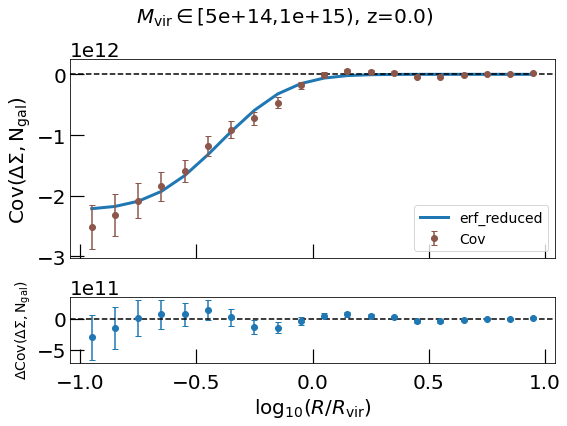

M5e+14-1e+15, z=0.49, 136
erf_reduced


100%|██████████| 20000/20000 [02:40<00:00, 124.48it/s]


R = [1.00123767 1.00192019 1.00272633]
param_0: best fit, upper_err, lower_err:  [0.61412803 0.26820312 0.24452992]
param_1: best fit, upper_err, lower_err:  [-0.90068076  0.49117487  0.76050299]
param_2: best fit, upper_err, lower_err:  [1.01333889e+12 3.04858608e+12 5.97244008e+11]
DIC:  [1070.29617018]
BIC:  [1074.3997467]
Chi-square p-value:  0.9476705936953685
Starting params:  [ 4.60557233e-01 -5.12113560e-01  5.61417067e+11] Minimization convergence:  False


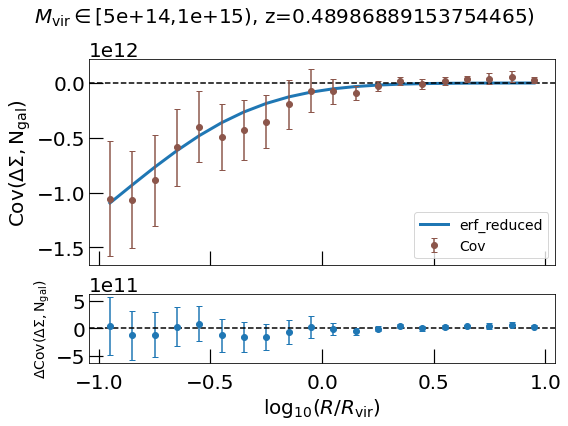

M5e+14-1e+15, z=1.03, 5


In [9]:
from scipy import stats
import scipy.optimize as opt
import emcee
import tqdm

nBootstrap = 20

#fig, axs = plt.subplots(4,3,figsize=(18,18), tight_layout=True, sharex=True)

for i, cur_mass_bin in enumerate(mass_bins):
    for j, cur_a_bin in enumerate(a_bins):     
            mass_min = cur_mass_bin[0]; mass_max = cur_mass_bin[1]
            mask = (matched_halo_df.M200c >= mass_min) & (matched_halo_df.M200c < mass_max) & (matched_halo_df.scale == cur_a_bin) 
            cur_df = matched_halo_df[mask]
            print('M{:.2g}-{:.2g}, z={:.2f}, {}'.format(mass_min, mass_max, 1/cur_a_bin-1, len(cur_df)))

            redshift = 1/cur_a_bin - 1
            redshift_str = '{:.2f}'.format(redshift)
            redshift_str = redshift_str.replace('.','p')

            if len(cur_df) < 100: 
                #axs[i,j].set_visible(False)
                continue

            ##Computing the Covariance##
            ##Compute Cov. and error total
            xline, output = calc_cov_KLLR(np.log10(np.array(cur_df['M200c'],dtype=float)) , np.array(np.vstack(cur_df['delta_sigma']), dtype=float), \
                                           np.log10(np.array(cur_df['Ngal_R200c'],dtype=float)), nBootstrap=nBootstrap)
            cov_ds_ngal_kllr = output['covariance']
            cov_mean_kllr = np.mean(cov_ds_ngal_kllr, axis=0)
            cov_err_kllr = np.std(cov_ds_ngal_kllr, axis=0)

            ##Data vector for chains
            x_data = r_cent_log_norm; y_data = cov_mean_kllr; y_err = cov_err_kllr

            f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(8,6), sharex=True)
            k=0
            for key, value in model_dict.items():
                print(key)
                #if key == 'erf': continue 
                Ndim = value['Ndim']
                model = value['model_func']
                x0 = value['x0']

                filename = chainsdir+"R200c_binned/Dsep_R200c/chains_M{:.2g}_{:.2g}_z{}_{}.h5py".format(mass_min, mass_max, redshift_str, key)

                best_fit_params, flatchain = run_model_chains(Nwalkers, Ndim, Nsample, model, x_data, y_data, y_err, x0, \
                                 burn_in=burn_in, thin=thin, maxlag=maxlag, savefile=True, filename=filename, verbose=True)

                model_dict[key]['x_final'] = best_fit_params
                fit = model(best_fit_params[:,0], x_data)


                a0.plot(x_data, fit, label=key, color='C{}'.format(k), linewidth=3)
                a1.errorbar(x_data, y_data-fit, yerr=y_err, marker="o", capsize=3, linestyle='None',color='C{}'.format(k), label=key)
                k+=1

            a0.axhline(0, linestyle='--', color='black')
            a0.errorbar(x_data, y_data, yerr=y_err, label='Cov', marker="o", capsize=3, linestyle='None', color='C5')  
            a0.legend(loc='lower right', fontsize=14)
            a0.set_ylabel(r'$\rm{Cov}(\Delta\Sigma, N_{\rm gal})$', fontsize=20)

            a1.axhline(0, linestyle='--', color='black')
            #a1.set_ylim([-6e11,3e11])
            a1.set_ylabel(r'$\Delta \rm{Cov}(\Delta\Sigma, N_{\rm gal})$', fontsize=14)
            a1.set_xlabel(r'$\log_{10}(R/R_{\rm vir})$', fontsize=20)

            plt.suptitle(r'$M_{\rm vir} \in$' + '[{:.2g},{:.2g}), z={})'.format(mass_min, mass_max, 1/cur_a_bin-1), fontsize=20)

            f.tight_layout()
            #f.savefig(plot_dir+'cov_all_models_data_vs_fit_M{:.2g}_{:.2g}_z{}.pdf'.format(mass_min, mass_max, redshift_str))
            plt.show()

## Cornerplot

In [ ]:
import corner
tmp = corner.corner(flatchain.T, labels=['gamma', 'tau', 'h', r'$10^{12}\times s$'],
                    quantiles=[0.16, 0.5, 0.84],
                    show_titles=True,
                    title_kwargs={"fontsize": 12},
                    title_fmt='.2g',
                    #axes_scale=['linear','linear','linear','log'],
                    max_n_ticks=3,
                    use_math_text=True,
                    #range=[(0,0.4),(-2,0),(0.9,1),(1e12,1e13)]
                   )
for i, ax in enumerate(tmp.get_axes()):
    #if i==12: ax.set_xscale('log')
    #if i>=13: ax.set_yscale('log')
    ax.tick_params(axis='both', labelsize=12)
#tmp.savefig(plot_dir + 'mcmc_logistic_cornerplot.pdf')